In [1]:
import argparse
import sys
from PIL import Image
import numpy as np
import cv2
import os
import random
import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# import tensorwatch as tw

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset

from vit_rollout import VITAttentionRollout
from vit_grad_rollout import VITAttentionGradRollout

In [2]:
# Training settings
batch_size = 128
epochs = 1
lr = 3e-5
gamma = 0.7
seed = 42
device = 'cuda'

In [3]:
def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

In [4]:
# from tensorboardX import SummaryWriter
# writer = SummaryWriter('log') #建立一个保存数据用的东西
model = torch.hub.load('facebookresearch/deit:main', 
    'deit_tiny_patch16_224', pretrained=True)
model.head = nn.Linear(in_features = model.head.in_features, out_features = 2, bias = True)
model.to(device);

Using cache found in /home/a611/.cache/torch/hub/facebookresearch_deit_main


In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed)

## Load Data

In [6]:
train_dir = '/home/a611/Projects/Datasets/dogs-vs-cats/train'
test_dir = '/home/a611/Projects/Datasets/dogs-vs-cats/test'

train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")
labels = [path.split('/')[-1].split('.')[0] for path in train_list]

Train Data: 25000
Test Data: 12500


## Random Plots

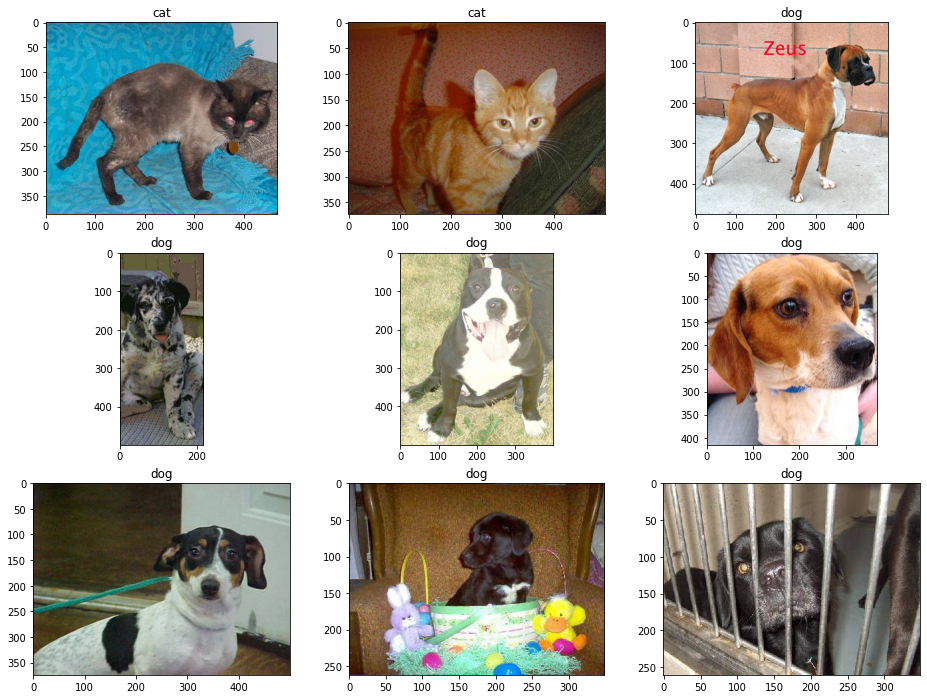

In [7]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

## Split

In [8]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)

print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 20000
Validation Data: 5000
Test Data: 12500


In [9]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

## Load Datasets

In [10]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split("/")[-1].split(".")[0]
        label = 0 if label == "dog" else 1

        return img_transformed, label


In [11]:
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [12]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [13]:
print(len(train_data), len(train_loader))
print(len(valid_data), len(valid_loader))

20000 157
5000 40


## Effecient Attention

### Training

In [14]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [15]:
for epoch in range(epochs):

    model.train()
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    model.eval()
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.0805 - acc: 0.9688 - val_loss : 0.0366 - val_acc: 0.9861



In [16]:
image = Image.open('18.jpg')
img = img.resize((224, 224))
input = test_transforms(image).unsqueeze(0)
input = input.to(device)
output = model(input)
output.argmax(dim=1)

tensor([0], device='cuda:0')

In [17]:
model.eval()
discard_ratio = 0.9

head_fusion = 'max' # How to fuse the attention heads for attention rollout. Can be mean/max/min.

attention_rollout = VITAttentionRollout(model, head_fusion = head_fusion, discard_ratio = discard_ratio)
mask = attention_rollout(input)
name = "attention_rollout_{:.3f}_{}.png".format(discard_ratio, head_fusion)

In [18]:
np_img = np.array(image)[:, :, ::-1]
mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))
mask = show_mask_on_image(np_img, mask)
cv2.imwrite(name, mask)

True